In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import os
import datetime
import numpy as np
import dill as pickle
import random
import sys
import seaborn as sns
import math
from matplotlib import rcParams
rcParams['figure.figsize'] = 25, 10
from collections import OrderedDict
from matplotlib.lines import Line2D
from pylab import rcParams
from collections import Counter
from itertools import combinations
from sklearn.decomposition import TruncatedSVD
from shutil import copyfile
import scipy

np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

from codes.experimentclasses.AtomicRegression2 import AtomicRegression
from codes.otherfunctions.get_dictionaries import get_all_atoms_4
from codes.flasso.Replicate import Replicate
from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.geometer.TangentBundle import TangentBundle
from codes.geometer.ShapeSpace import ShapeSpace
from codes.flasso.GradientGroupLasso import batch_stream, get_sr_lambda_sam_parallel
from codes.otherfunctions.get_grads import get_grads3

n = 50000 #number of data points to simulate
nsel = 100 #number of points to analyze with lasso
n_neighbors = 1000 #number of neighbors in megaman
m = 3 #number of embedding dimensions (diffusion maps)
diffusion_time = 1. #embedding radius
dim = 2 #manifold dimension
dimnoise = 2 #manifold dimension (not in mflasso paper)
cores = 3 
nreps = 5
natoms = 9

savename = 'ethanol_021521'
savefolder = 'ethanol'
loadfolder = 'ethanol'
loadname = 'ethanol_021521'
data_wd = '/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/'

folder = workingdirectory + '/Figures/ethanol/' + now + 'n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(nreps)
os.mkdir(folder)
experiment = AtomicRegression(natoms)
experiment.m = m
experiment.dim = dim
experiment.dnoise = dim
experiment.nreps = nreps
experiment.nsel = nsel
experiment.atoms3, experiment.da = experiment.get_atoms_3()
experiment.atoms4,experiment.p = get_all_atoms_4(natoms)

data_wd = '/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/'
data_xyz_loaded = scipy.io.loadmat(data_wd + '/untracked_data/chemistry_data/ethanol.mat')
angle_indices = np.load(data_wd + '/untracked_data/chemistry_data/ethanolindices022119.npy')
experiment.positions =  data_xyz_loaded['R'][angle_indices]
filename_angles = data_wd + '/untracked_data/chemistry_data/ethanolangles022119.npy'
data = np.arccos(np.reshape(np.load(filename_angles), (50000, experiment.da)))

experiment.M = RiemannianManifold(data, dim)#experiment.load_data(workingdirectory = data_wd)
experiment.svd = TruncatedSVD(n_components=50)
experiment.Mpca = RiemannianManifold(experiment.svd.fit_transform(experiment.M.data), dim)
experiment.Mpca.geom = experiment.Mpca.compute_geom(diffusion_time, n_neighbors)
experiment.N = experiment.Mpca.get_embedding3(experiment.Mpca.geom, m, diffusion_time, dim)



/Users/samsonkoelle/manifoldflasso_jmlr


In [ ]:
print('pre-gradient acquisition',datetime.datetime.now())
replicates = {}
for i in range(nreps):
    print('yessington')
    replicates[i] = Replicate(nsel = nsel, n = experiment.M.data.shape[0])
    replicates[i].df_M,replicates[i].dg_M,replicates[i].dg_w ,replicates[i].dg_w_pca ,replicates[i].dgw_norm, replicates[i].tangent_bases  = get_grads3(experiment, experiment.Mpca, experiment.M, experiment.N, replicates[i].selected_points,experiment.svd)


In [3]:

gl_itermax = 500
r = 0 
max_search = 30
reg_l2 = 0.
tol = 1e-14
learning_rate = 100
results= {}
for r in range(nreps):
    ul = np.linalg.norm(np.einsum('n m d, n p d -> n p m ' ,replicates[r].df_M , replicates[r].dg_M), axis = tuple([0,2])).max()
    lambdas_start = [0.,ul]
    #to fix...
    replicates[r].dg_M = np.swapaxes(replicates[r].dg_M,1,2)
    replicates[r].df_M = np.swapaxes(replicates[r].df_M,1,2)
    replicates[r].results = get_sr_lambda_sam_parallel(replicates[r], gl_itermax, lambdas_start,reg_l2, max_search, dim, tol,learning_rate)
    

initializing lambda search
converged 1092.6161552570834
0 546.3080776285417 probe
1 819.4621164428125 probe
2 956.039135849948 probe
converged 956.039135849948
3 1024.3276455535156 probe
converged 1024.3276455535156
4 990.1833907017318 probe
we did it [213 745]
initializing lambda search
converged 1096.1290112495103
0 548.0645056247552 probe
1 822.0967584371327 probe
2 959.1128848433216 probe
we did it [213 721]
initializing lambda search
converged 1076.6005914928073
0 538.3002957464037 probe
1 807.4504436196055 probe
2 942.0255175562064 probe
converged 942.0255175562064
we did it [588 721]
initializing lambda search
converged 1096.4270475164178
0 548.2135237582089 probe
1 822.3202856373134 probe
2 959.3736665768656 probe
converged 959.3736665768656
3 1027.9003570466416 probe
converged 1027.9003570466416
4 1062.1637022815298 probe
converged 1062.1637022815298
5 1045.0320296640857 probe
converged 1045.0320296640857
we did it [721 740]
initializing lambda search
converged 1085.7344443428

In [2]:
g_722 = experiment.get_g_full_sub(experiment.M.data, experiment.atoms4[722])

In [3]:
g_745 = experiment.get_g_full_sub(experiment.M.data, experiment.atoms4[745])

In [4]:
g_721 = experiment.get_g_full_sub(experiment.M.data, experiment.atoms4[721])

In [5]:
g_740 = experiment.get_g_full_sub(experiment.M.data, experiment.atoms4[740])

In [6]:
g_588 =  experiment.get_g_full_sub(experiment.M.data, experiment.atoms4[588])



In [7]:
g_213 =  experiment.get_g_full_sub(experiment.M.data, experiment.atoms4[213])

Text(0.5, 0, '$\\phi_3$')

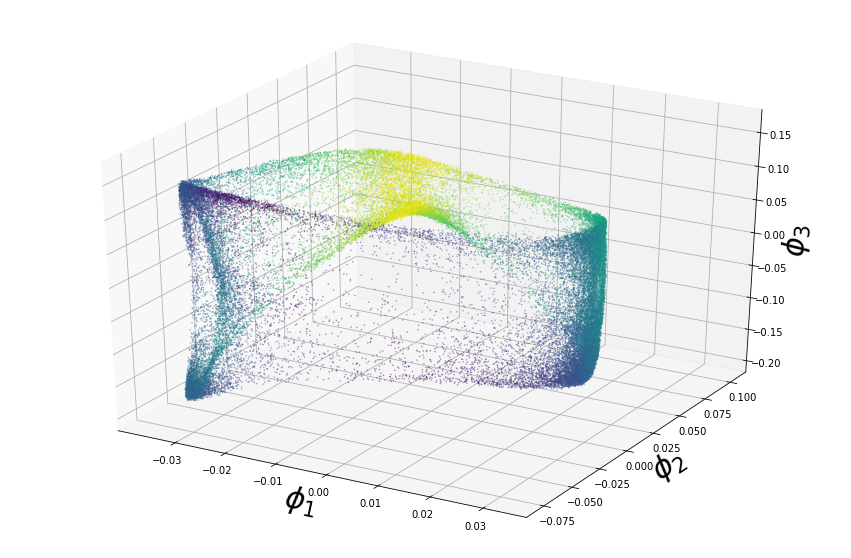

In [8]:
%matplotlib inline

data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1, projection='3d')

#ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z,  s=s,c = g_722, alpha=alpha, marker='.',vmin = 0, vmax=  np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 30)
ax.set_ylabel(r'$\phi_2$', fontsize = 30)
ax.set_zlabel(r'$\phi_3$', fontsize = 30)

Text(0.5, 0, '$\\phi_3$')

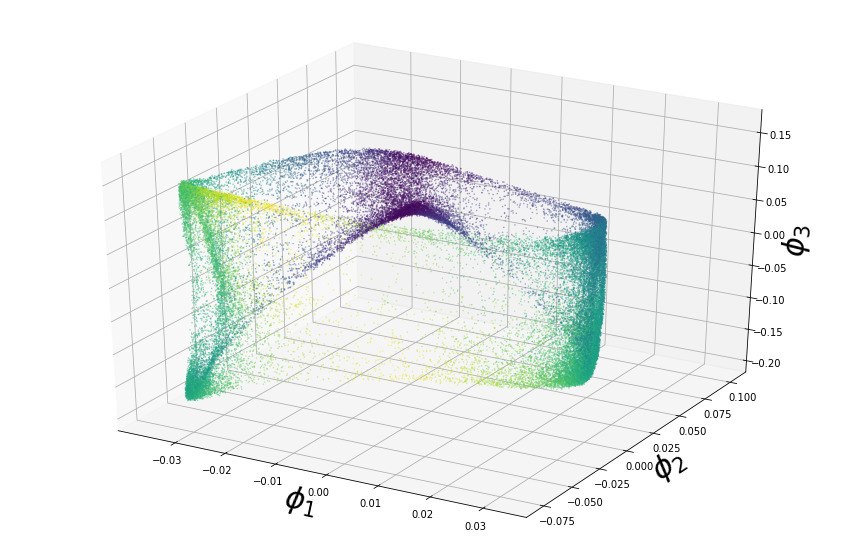

In [9]:
%matplotlib inline

data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1, projection='3d')

#ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z,  s=s,c = g_721, alpha=alpha, marker='.',vmin = 0, vmax=  np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 30)
ax.set_ylabel(r'$\phi_2$', fontsize = 30)
ax.set_zlabel(r'$\phi_3$', fontsize = 30)

Text(0.5, 0, '$\\phi_3$')

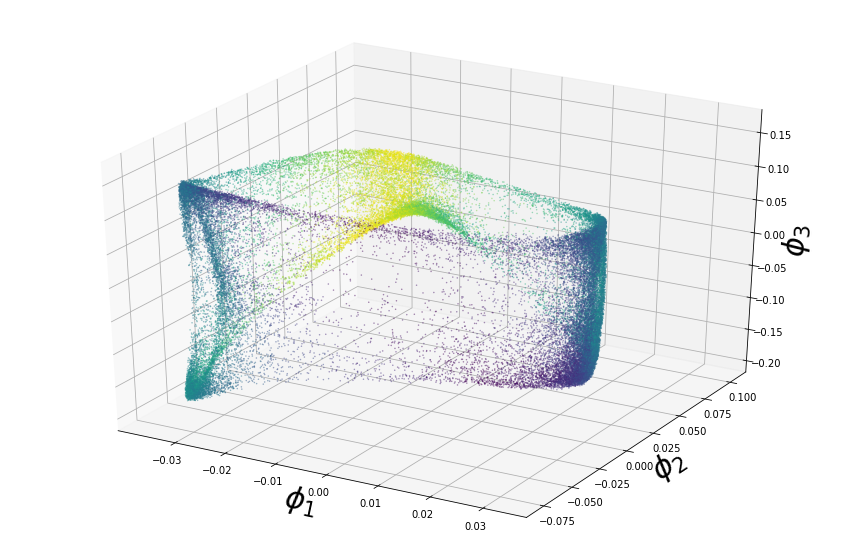

In [10]:
%matplotlib inline

data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1, projection='3d')

#ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z,  s=s,c = g_740, alpha=alpha, marker='.',vmin = 0, vmax=  np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 30)
ax.set_ylabel(r'$\phi_2$', fontsize = 30)
ax.set_zlabel(r'$\phi_3$', fontsize = 30)

Text(0.5, 0, '$\\phi_3$')

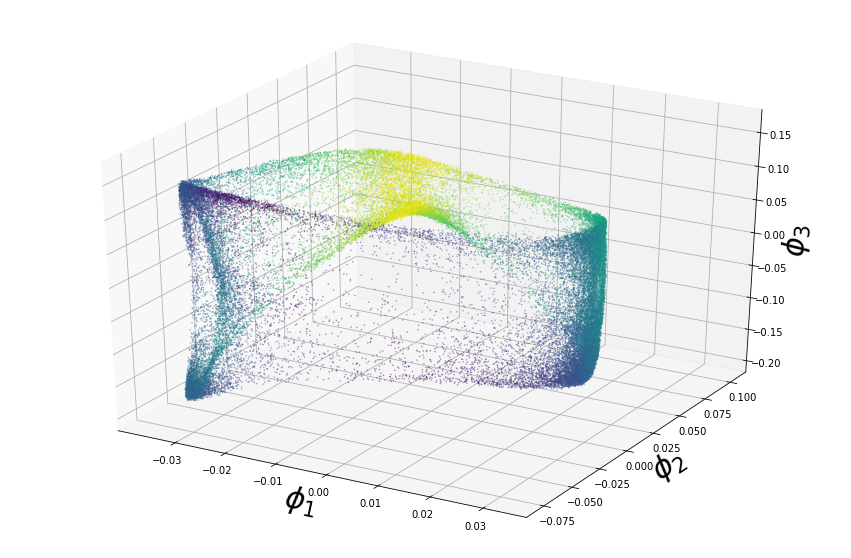

In [11]:
%matplotlib inline

data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1, projection='3d')

#ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z,  s=s,c = g_722, alpha=alpha, marker='.',vmin = 0, vmax=  np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 30)
ax.set_ylabel(r'$\phi_2$', fontsize = 30)
ax.set_zlabel(r'$\phi_3$', fontsize = 30)

Text(0.5, 0, '$\\phi_3$')

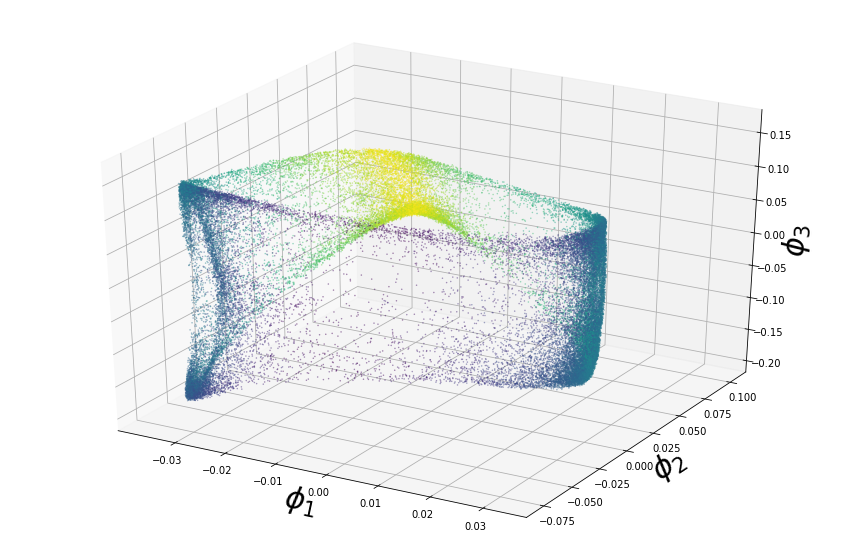

In [13]:
%matplotlib inline

data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1, projection='3d')

#ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z,  s=s,c = g_588, alpha=alpha, marker='.',vmin = 0, vmax=  np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 30)
ax.set_ylabel(r'$\phi_2$', fontsize = 30)
ax.set_zlabel(r'$\phi_3$', fontsize = 30)

Text(0.5, 0, '$\\phi_3$')

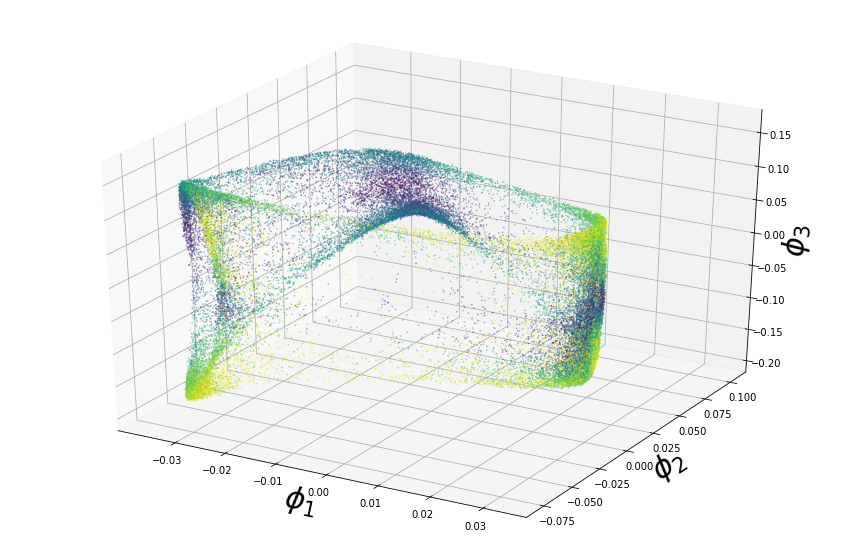

In [15]:
%matplotlib inline

data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1, projection='3d')

#ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z,  s=s,c = g_213, alpha=alpha, marker='.',vmin = 0, vmax=  np.pi/3)
ax.set_xlabel(r'$\phi_1$', fontsize = 30)
ax.set_ylabel(r'$\phi_2$', fontsize = 30)
ax.set_zlabel(r'$\phi_3$', fontsize = 30)

In [ ]:
replicates_small = {}
for r in range(nreps):
    replicates_small[r] = Replicate(nsel = nsel, n = experiment.M.data.shape[0], selected_points=replicates[r].selected_points)
    replicates_small[r].dg_M = replicates[r].dg_M
    replicates_small[r].df_M = replicates[r].df_M
    cos = get_cosines(np.swapaxes(replicates_small[r].dg_M,1,2))
    replicates_small[r].cos = cos